In [52]:
import numpy as np
import sys
import matplotlib.pyplot as plt

class proj(object):
    def __init__(self, h, w, pred_max_depth):
        self.h = h
        self.w = w
        self.pred_max_depth = pred_max_depth
        
        self.P = np.array([
        [1472.919866, 0., 614.779599, 0.],
        [0., 1452.953534, 353.800982, 0.],
        [0., 0., 1., 0.]
        ])
        
        self.R0 = np.array([
            [1., 0., 0.],
            [0., 1., 0.],
            [0., 0., 1.]
            ])
        
        self.Rt = np.array([
            [0., -1., 0., 0.],
            [0., 0., -1., 0.],
            [1., 0., 0., 0.]
            ])
        # self.Rt_2to3 = Params['Rt_2to3']
        
    def get_2dpixel_from_3dpoints(self, points, stereo):
        def process(Rt):
            lidar_points_3d_hom = self.get_hom_coord_from_point(points)
            after_Rt_point = self.projection_Rt(lidar_points_3d_hom, Rt)
            after_R0_point = self.projection_R0(after_Rt_point)
            after_P_point = self.projection_P(after_R0_point)
            lidar_pixel_coord, lidar_pixel_depth = self.get_pixel_point(after_P_point)
            pixel_coord_in_imgfov, pixel_depth_in_imgfov = self.get_pc_depth_in_fov(lidar_pixel_coord, lidar_pixel_depth)
            # depth_image_from_lidar, GT_depth_in_lidar = self.get_depth_map(pixel_coord_in_imgfov, pixel_depth_in_imgfov, depth_image)
            depth_map = self.get_depth_map_from_lidar(pixel_coord_in_imgfov, pixel_depth_in_imgfov)
            depth_map = np.expand_dims(depth_map, axis=-1)
            return depth_map
        
        depth_map = process(self.Rt)
        if stereo:
            r_depth_map = process(self.Rt_2to3)
            plt.imshow(r_depth_map)
            plt.show()
            sys.exit()
            depth_map = np.concatenate((depth_map, r_depth_map), axis=-1)
        
        return depth_map
    
    def get_depth_map_from_lidar(self, pixel_coord_in_imgfov, GT_depth_in_lidar):
        GT_depthmap_in_lidar16 = np.ones((self.h, self.w), dtype=np.float64)*-1.
        for i in range(pixel_coord_in_imgfov.shape[0]):
            x_coord, y_coord = pixel_coord_in_imgfov[i]
            x_coord = np.floor(x_coord).astype(np.int32)
            y_coord = np.floor(y_coord).astype(np.int32)
            GT_depthmap_in_lidar16[y_coord, x_coord] = GT_depth_in_lidar[i]
        depth_map = GT_depthmap_in_lidar16
        depth_map[depth_map>=self.pred_max_depth] = -1
        
        return depth_map
    
    def get_hom_coord_from_point(self, points):
        ones_row = np.ones((1, points.T.shape[1]))
        lidar_points_3d_T = points.T
        lidar_points_3d_hom = np.vstack((lidar_points_3d_T, ones_row))
        return lidar_points_3d_hom
    
    def projection_Rt(self, lidar_points_3d_hom, Rt):
        after_Rt_point = np.dot(Rt, lidar_points_3d_hom)
        return after_Rt_point
    
    def projection_R0(self, after_Rt_point):
        after_R0_point = np.dot(self.R0, after_Rt_point)
        return after_R0_point
    
    def projection_P(self, after_R0_point):
        ones_row = np.ones((1, after_R0_point.shape[1]))
        after_R0_point_4xn = np.vstack((after_R0_point, ones_row))
        after_P_point = np.dot(self.P, after_R0_point_4xn)
        return after_P_point
    
    def get_pixel_point(self, after_P_point):
        lidar_proj = after_P_point.T
        lidar_proj[:, 0] /= lidar_proj[:, 2]
        lidar_proj[:, 1] /= lidar_proj[:, 2]
        lidar_pixel_coord = lidar_proj[:, 0:2]
        lidar_pixel_depth = lidar_proj[:, 2]
        return lidar_pixel_coord, lidar_pixel_depth
    
    def get_pc_depth_in_fov(self, lidar_pixel_coord, lidar_pixel_depth):
        clip_distance = 0
        fov_inds = (
            (lidar_pixel_coord[:, 0] < self.w)
            & (lidar_pixel_coord[:, 0] >= 0)
            & (lidar_pixel_coord[:, 1] < self.h)
            & (lidar_pixel_coord[:, 1] >= 0)
        )
        fov_inds = fov_inds & (lidar_pixel_depth > clip_distance)
        pixel_coord_in_imgfov = lidar_pixel_coord[fov_inds, :]
        pixel_depth_in_imgfov = lidar_pixel_depth[fov_inds]
        return pixel_coord_in_imgfov, pixel_depth_in_imgfov
    
    def get_depth_map(self, pixel_coord_in_imgfov, pixel_depth_in_imgfov, depth_image):
        GT_depth_in_lidar = []
        # depth_values = depth_image[:,:,0]*80./255.
        depth_values = depth_image
        depth_image_from_lidar = np.zeros((self.h, self.w), dtype=np.float64)
        for i in range(pixel_coord_in_imgfov.shape[0]):
            x_coord, y_coord = pixel_coord_in_imgfov[i]
            x_coord = np.floor(x_coord).astype(np.int32)
            y_coord = np.floor(y_coord).astype(np.int32)
            depth_image_from_lidar[y_coord, x_coord] = pixel_depth_in_imgfov[i]
            GTdepth = depth_values[y_coord, x_coord]
            GT_depth_in_lidar.append(GTdepth)
        GT_depth_in_lidar = np.array(GT_depth_in_lidar, dtype=np.float64)
        return depth_image_from_lidar, GT_depth_in_lidar

In [53]:
import numpy as np
import sys

class inv_proj(object):
    def __init__(self, img_width, img_height):
        self.w = img_width
        self.h = img_height
        self.c = 3
        
        self.P_ = np.array([
        [1472.919866, 0., 614.779599],
        [0., 1452.953534, 353.800982],
        [0., 0., 1.]
        ])
        
        self.R0 = np.array([
            [1., 0., 0.],
            [0., 1., 0.],
            [0., 0., 1.]
            ])
        
        self.Rt = np.array([
            [0., -1., 0., 0.],
            [0., 0., -1., 0.],
            [1., 0., 0., 0.]
            ])
        
        self.R_ = self.Rt[:, :3]
        
    def get_3dpoint_from_depthmap(self, depth_image):
        imageplane_depth = self.get_pixel_depth(depth_image)
        after_P__depth = self.inverse_projection_P(imageplane_depth)
        after_R0_depth = self.inverse_projection_R0(after_P__depth)
        after_Rt_depth = self.inverse_projection_Rt(after_R0_depth)
        depth_point_3d = after_Rt_depth.T
        return depth_point_3d
        
    def get_pixel_depth(self, depth_image):
        depth_values = depth_image[:,:]
        
        nonzero_indices = np.nonzero(depth_values)
        coordinates_values = []
        for i in range(len(nonzero_indices[0])):
            x = nonzero_indices[0][i]
            y = nonzero_indices[1][i]
            value = depth_values[x, y]
            coordinates_values.append([x, y, value])
            
        pixel_depth = np.array(coordinates_values)
        pixel_depth = pixel_depth.astype(float)
        imageplane_depth = np.zeros(pixel_depth.shape)
        imageplane_depth[:, 0] = pixel_depth[:, 1] * pixel_depth[:, 2]
        imageplane_depth[:, 1] = pixel_depth[:, 0] * pixel_depth[:, 2]
        imageplane_depth[:, 2] = pixel_depth[:, 2]
        imageplane_depth_T = imageplane_depth.T
        
        return imageplane_depth_T
    
    def inverse_projection_P(self, imageplane_depth):
        # after_b_tr_depth = imageplane_depth - self.translation_vector_b
        after_P_depth = np.dot(np.linalg.inv(self.P_), imageplane_depth)
        return after_P_depth
    
    def inverse_projection_R0(self, after_P__depth):
        after_R0_depth = np.dot(np.linalg.inv(self.R0), after_P__depth)
        return after_R0_depth
    
    def inverse_projection_Rt(self, after_R0_depth):
        # after_t_depth = after_R0_depth - self.translation_vector_t
        after_Rt_depth = np.dot(np.linalg.inv(self.R_), after_R0_depth)
        return after_Rt_depth

In [54]:
import open3d as o3d

def create_point_cloud(points_3D):
    # Convert points to Open3D format
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_3D)
    return pcd

def visualize_point_cloud(points_3D):
    # Create the point cloud
    # pcd = create_point_cloud(points_3D)
    
    # If points_3D is already a PointCloud object, skip creating a new one
    if isinstance(points_3D, o3d.geometry.PointCloud):
        pcd = points_3D  # Use the existing PointCloud object
    else:
        # Create the point cloud
        pcd = create_point_cloud(points_3D)
    
    # Visualize the point cloud
    o3d.visualization.draw_geometries([pcd])

In [55]:
from PIL import Image
import numpy as np
import cv2

depth_map_file = "data/dense_depth_map/1623170280811.png"
depth = cv2.imread((depth_map_file), cv2.IMREAD_GRAYSCALE)


pcd = inv_proj(1280, 720).get_3dpoint_from_depthmap(depth)
vis = create_point_cloud(pcd)
visualize_point_cloud(vis)


In [56]:
# from depth2voxel import Depth2Voxel

class VoxelPlanarityCalculator:
    def __init__(self, voxel_grid, point_cloud, planarity_threshold):
        self.voxel_grid = voxel_grid
        self.point_cloud = np.asarray(point_cloud.points) if not isinstance(point_cloud, np.ndarray) else point_cloud
        self.planarity_threshold = planarity_threshold
        self.planarity_dict = {}

    def calculate_planarity(self):
        voxel_dict = {}

        # 포인트를 복셀에 할당
        for point in self.point_cloud:
            voxel_index = tuple(self.voxel_grid.get_voxel(point))
            voxel_dict.setdefault(voxel_index, []).append(point)

        # 각 복셀에 대해 평탄도 계산
        for voxel_index, voxel_points in voxel_dict.items():
            voxel_points = np.array(voxel_points)
            
            if len(voxel_points) > 10:
                points_mean = np.mean(voxel_points, axis=0)
                centered_points = voxel_points - points_mean

                cov_matrix = np.cov(centered_points, rowvar=False)
                eigenvalues, _ = np.linalg.eigh(cov_matrix)
                eigenvalues = np.sort(eigenvalues)[::-1]

                planarity = min(((eigenvalues[1] - eigenvalues[2]) * 2) / eigenvalues[0], 1.0) if eigenvalues[0] > 0 else 0
            else:
                planarity = 0

            self.planarity_dict[voxel_index] = planarity

        return self.planarity_dict

    def visualize_planarity(self):
        colors = []

        for point in self.point_cloud:
            voxel_index = tuple(self.voxel_grid.get_voxel(point))
            planarity = self.planarity_dict.get(voxel_index, 0)
            
            # 평탄도가 임계값 이상인 복셀만 빨간색으로 표시, 나머지는 검은색
            color = [1, 0, 0] if planarity >= self.planarity_threshold else [0, 0, 0]
            colors.append(color)

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(self.point_cloud)
        pcd.colors = o3d.utility.Vector3dVector(np.array(colors))

        # save
        o3d.visualization.draw_geometries([pcd])

        # 저장
        pcd_np = np.asarray(pcd.points)
        colors_np = np.asarray(colors)
        return pcd_np, colors_np
        
        # np.save('data/pcd_points.npy', pcd_np)
        # np.save('data/pcd_colors.npy', colors_np)

def convert_to_voxel_grid(points_3D, voxel_size=0.05):
        # Convert point cloud to Open3D format
        pcd = create_point_cloud(points_3D)
        
        # Convert point cloud to Voxel Grid
        voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)
        
        return voxel_grid

# depth_map = converter.load_depth_map(depth_map_file)
# points_3D = converter.depth_to_point_cloud(depth_map)
voxel_grid = convert_to_voxel_grid(pcd, voxel_size=0.25)

calculator = VoxelPlanarityCalculator(voxel_grid, pcd, planarity_threshold=0.7)
planarity_dict = calculator.calculate_planarity()
pcd_np, colors_np = calculator.visualize_planarity()

In [57]:
import sys
colors_np

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]])

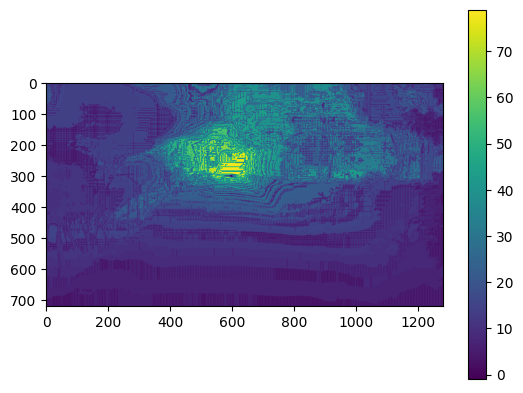

In [58]:
projected_image = proj(720, 1280, 80).get_2dpixel_from_3dpoints(pcd_np, False)

plt.imshow(projected_image)
plt.colorbar()
plt.show()

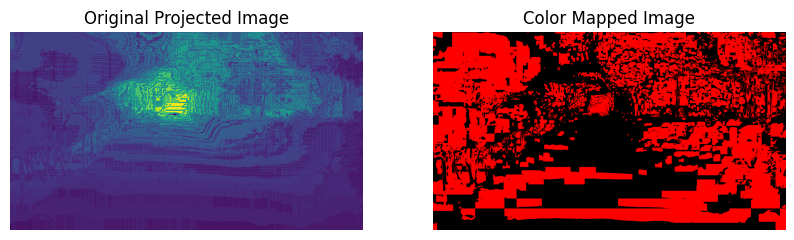

In [59]:
height, width, _ = projected_image.shape
color_mapped_image = np.zeros((height, width, 3), dtype=np.uint8)

# colors_np를 2차원 인덱스로 변환하여 각 픽셀에 적용
color_mapped_image = colors_np.reshape(height, width, 3) * 255

# 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Projected Image")
plt.imshow(projected_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Color Mapped Image")
plt.imshow(color_mapped_image)
plt.axis('off')

plt.show()

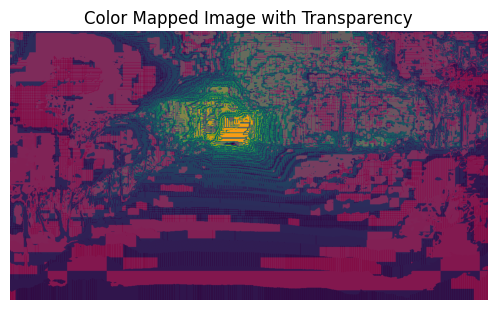

In [60]:
# 컬러 이미지에 알파 채널 추가
height, width, _ = projected_image.shape
color_mapped_image = np.zeros((height, width, 4), dtype=np.uint8)

rgb_values = colors_np.reshape(height, width, 3) * 255
alpha_value = 0.8  # 0부터 1까지
color_mapped_image[:, :, :3] = rgb_values
color_mapped_image[:, :, 3] = int(alpha_value * 255)

# 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 2)
plt.title("Color Mapped Image with Transparency")
plt.imshow(projected_image)  # 배경으로 원본 이미지 표시
plt.imshow(color_mapped_image, alpha=alpha_value / 2)  # 투명한 컬러 매핑 이미지
plt.axis('off')

plt.tight_layout()
plt.show()
